In [1]:
import csv
import datetime, pytz
from datetime import datetime, timedelta
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
temp_01 = pd.read_csv("data/2018-2019 data pt 1_Oct 01 2018 to Jan 31 2019.csv")
temp_02 = pd.read_csv("data/2018-2019 data pt 2_ Feb 01 2019 to May 31 2019.csv")
df = pd.concat([temp_01, temp_02])

# remove all columns except for "created_at" and "violation"
# TODO: why doesn't this work
df.drop(columns=['user_id', 'address', 'zip_code', 'apartment', 'sensor_id', 'bbl', 'temp', 'outdoor_temp'])
df.head()

,user_id,address,zip_code,apartment,sensor_id,bbl,temp,created_at,outdoor_temp,violation
0,381.0,124 E 176th St,10453.0,6J,feather0090,2.028260e+09,66,2019-01-30 23:58:43,11.0,True
1,390.0,1802 Ocean Parkway,11223.0,C4,feather0101,3.066810e+09,69,2019-01-30 23:58:19,14.0,False
2,492.0,341 E 19th St,11226.0,3E,feather0118,3.051620e+09,68,2019-01-30 23:54:54,13.0,False
3,389.0,4836 41st St,11104.0,2F,feather0024,4.002020e+09,50,2019-01-30 23:50:40,16.0,True
4,167.0,150 Court St,11201.0,NaN,feather0115,3.002920e+09,69,2019-01-30 23:50:16,14.0,False


In [6]:
# Modified from Archived Scripts/Consec Violation Hist and Day Time_eda.ipynb

def bin_by_time(dataframe, time, day_night):
    
    """
    Bins all temperature violations (as defined by NY law) in the csv file by hour
    :param input_csv: path to input csv
    :type input_csv: str
    :param time: the aspect of timestamp to bin by, e.g. month, day, hour.
    :type time: str
    :param day_night: the time of day (day or night) to look at.
    :type day_night: str
    :return: dictionary of lists where keys are time slices, values are lists of records where a violation occured
    :rtype: dict(list)
    """
    
    # keys are values of time parameter, values are lists of rows
    violations = defaultdict(list)
    for row in df.itertuples(index=False):
        created_at = getattr(row, "created_at")
        if getattr(row, "violation") == True:
            created = datetime.strptime(created_at, "%Y-%m-%d %H:%M:%S")
            # datetime formatting to convert UTC to EST or EDT as appropriate
            # for EDA only! stick to UTC for actual automation.
            # hardcoding timezone since our domain is very constrained.
            created = created.replace(tzinfo=pytz.utc)
            created = created.astimezone(pytz.timezone('US/Eastern'))
            if day_night == "day":
                if created.hour >= 6 and created.hour <= 21:
                    violations[getattr(created, time)].append(row)
                    # looking only at day time hours
            elif day_night == "night":
                if created.hour >= 22 or created.hour <= 5:
                    violations[getattr(created, time)].append(row)
                    # looking only at night time hours
            else:
                violations[getattr(created, time)].append(row)
            # modified the code from Daniel to output only Day time hour data, Night time hour data, or AlL
    return violations


def plot_time_bins(title, time_bins):
    """
    Make a bar graph of total violations across all users with a bin for each time
    :param time_bins: a dictionary of lists keyed by time, value is list of violations occurring during that time
    :type time_bins: dict[list]
    :param label: the label for the x axis of the plot (what type of time slice this is)
    :type label: str
    """
    
    violations_per_time = []
    tick_labels = []
    # get tick labels in order
    for time_slice, records in sorted(time_bins.items(), key=lambda x: x[0]):
        violations_per_time.append(len(records))
        tick_labels.append(time_slice)
        print(str(time_slice) + ': ' + str(len(records)))
    
    plt.bar(range(len(violations_per_time)), violations_per_time, tick_label=tick_labels)
    plt.title(title)
    plt.xlabel('Hour of the Day (US/Eastern)')
    plt.ylabel('Total Violations')
    plt.show()

6: 865
7: 715
8: 581
9: 547
10: 524
11: 483
12: 459
13: 449
14: 448
15: 452
16: 481
17: 494
18: 522
19: 489
20: 476
21: 479


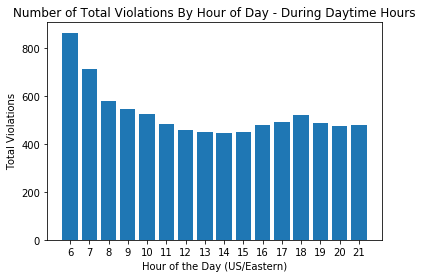

In [7]:
time_bins = bin_by_time(df, 'hour', 'day')
plot_time_bins('Number of Total Violations By Hour of Day - During Daytime Hours', time_bins)

0: 176
1: 185
2: 197
3: 196
4: 202
5: 205
22: 175
23: 177


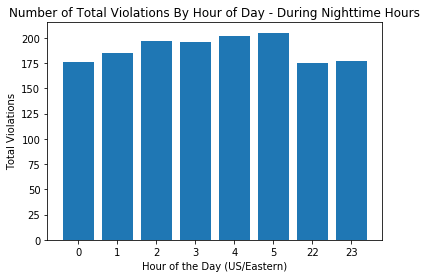

In [8]:
time_bins = bin_by_time(df, 'hour', 'night')
plot_time_bins('Number of Total Violations By Hour of Day - During Nighttime Hours', time_bins)

0: 176
1: 185
2: 197
3: 196
4: 202
5: 205
6: 865
7: 715
8: 581
9: 547
10: 524
11: 483
12: 459
13: 449
14: 448
15: 452
16: 481
17: 494
18: 522
19: 489
20: 476
21: 479
22: 175
23: 177


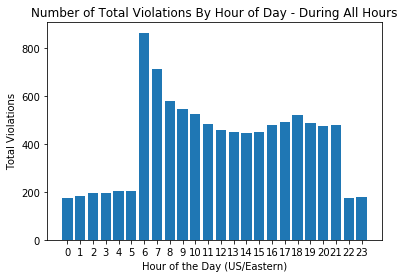

In [10]:
time_bins = bin_by_time(df, 'hour', 'all')
plot_time_bins('Number of Total Violations By Hour of Day - During All Hours', time_bins)